# Convolutional Neural Network

In this file, we will be addressing our take on the problem using a **convolutional neural network**.

We will begin  by importing the necessary modules:

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import pandas as pd
import keras
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import os
import librosa
import librosa.display
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2024-12-02 16:09:20.517063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 16:09:20.909399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis and Preprocessing

In [3]:
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


As per mentioned in the **project statement**, the target variable corresponds to the correct labeling of the sound. There are 10 different possible sounds in the dataset:

 - air conditioner
 - car horn
 - children playing
 - dog bark
 - drilling
 - engine idling
 - gun shot
 - jackhammer
 - siren
 - street music


We can already find the `classID` column, which essentially represents each label as an integer, from 0 to 9:


In [4]:
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")

for index, row in class_id_pairs.iterrows():
    print(f'classID: {row["classID"]}, class: {row["class"]}')

classID: 0, class: air_conditioner
classID: 1, class: car_horn
classID: 2, class: children_playing
classID: 3, class: dog_bark
classID: 4, class: drilling
classID: 5, class: engine_idling
classID: 6, class: gun_shot
classID: 7, class: jackhammer
classID: 8, class: siren
classID: 9, class: street_music


This means that we can remove the last column and begin working with our dataset, which we already determined is slightly unbalanced for the `car_horn` and `gunshot` values: 

In [5]:
# Map class IDs to class names
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")
class_labels = class_id_pairs['class'].values

# Drop the 'class' column
df.drop(columns=['class'], inplace=True)

Before proceeding, we decided to check if our dataset is imbalanced.

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['classID'])  
plt.title("Class Distribution for the Entire Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


KeyboardInterrupt



Classes of ID 1 and 6 show significant imbalance, when compared to other classes' counts. 

No over or under sampling techniques will be applied throughout this notebook, but imbalance was taken into consideration while evaluating each model's performance.

## Feature Extraction

When working with audio data, especially in the context of urban sound classification, it is highly beneficial to transform raw audio signals into **2D representations**. These representations capture both temporal and frequency information, leveraging the strengths of **Convolutional Neural Networks (CNNs)** in processing spatial data.

To achieve this, we use the `librosa` library to extract a variety of **audio features**, each capturing unique aspects of the sound. These features include:

- **Mel Spectrograms**: Representing the power spectrum of the audio signal on a Mel scale, capturing pitch and loudness over time.
- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Extracting features that model the short-term power spectrum of the sound, commonly used in speech and audio recognition.
- **Chroma Features**: Representing the energy distribution across different pitch classes, useful for tonal and harmonic analysis.
- **Spectral Contrast**: Highlighting the difference between peaks and valleys in the spectrum, useful for differentiating sound textures.
- **Spectral Rolloff**: Measuring the frequency below which a specified percentage of the total spectral energy is concentrated, often used for timbre classification.
- **Zero-Crossing Rate**: Counting the number of times the signal crosses the zero amplitude line, commonly used for identifying percussive sounds.

By utilizing these features, we can create a **multi-stream CNN** architecture. This design processes different feature sets in parallel, enhancing the model's ability to learn **complex patterns** in the audio data. Each feature provides a unique perspective on the signal, and their combination allows the model to make more informed and accurate predictions.

In [6]:
def extract_features(audio_path, sample_rate=22050, duration=4):
    # Load and preprocess audio
    signal, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
    signal = librosa.util.fix_length(signal, size=sample_rate * duration)

    # Extract features
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mfccs = librosa.feature.mfcc(S=mel_spec_db, n_mfcc=40)

    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)

    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=signal)

    return {
        'mel_spec': mel_spec_db,
        'mfccs': mfccs,
        'chroma': chroma,
        'spectral_contrast': spectral_contrast,
        'spectral_rolloff': spectral_rolloff,
        'zero_crossing_rate': zero_crossing_rate
    }

Before we proceed to extract features from all audio files, let's test our **extract_features** function on a sample audio file and visualize the features to ensure they are being extracted correctly.

In [7]:
# Select a sample audio file
sample_row = df.sample(n=1).iloc[0]
audio_path = f"UrbanSound8K/audio/fold{sample_row['fold']}/{sample_row['slice_file_name']}"

# Extract features
features = extract_features(audio_path)

# Display the audio path and class
print(f"Audio Path: {audio_path}")
print(f"Class ID: {sample_row['classID']}")


Audio Path: UrbanSound8K/audio/fold9/105029-7-2-12.wav
Class ID: 7


### Mel Spectogram

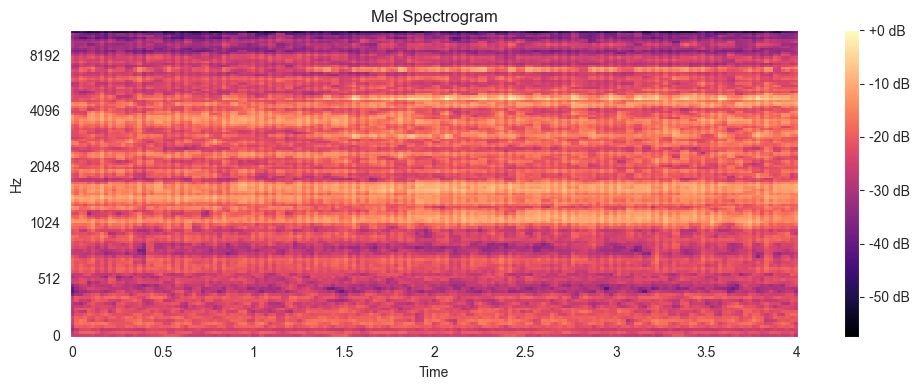

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features['mel_spec'], sr=22050, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### MFCCs (Mel-Frequency Cepstral Coefficients)

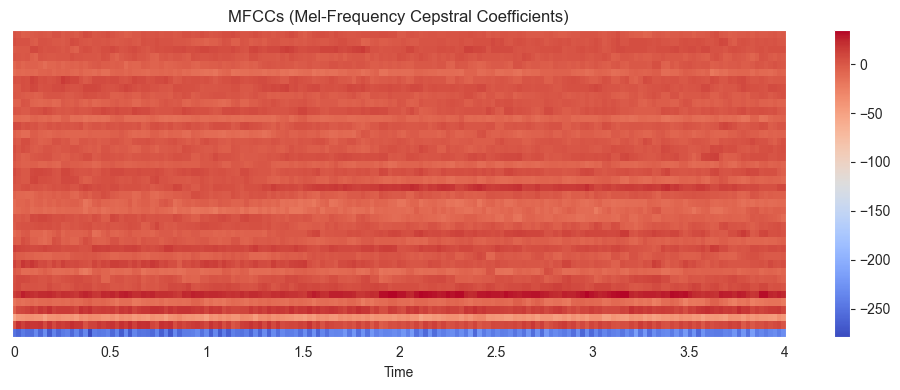

In [9]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features['mfccs'], sr=22050, x_axis='time')
plt.title('MFCCs (Mel-Frequency Cepstral Coefficients)')
plt.colorbar()
plt.tight_layout()
plt.show()

### Chroma Features

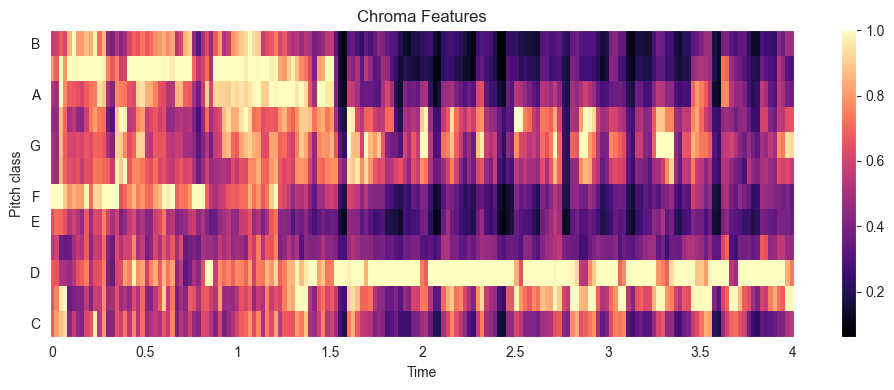

In [10]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features['chroma'], sr=22050, x_axis='time', y_axis='chroma')
plt.title('Chroma Features')
plt.colorbar()
plt.tight_layout()
plt.show()

### Spectral Contrast

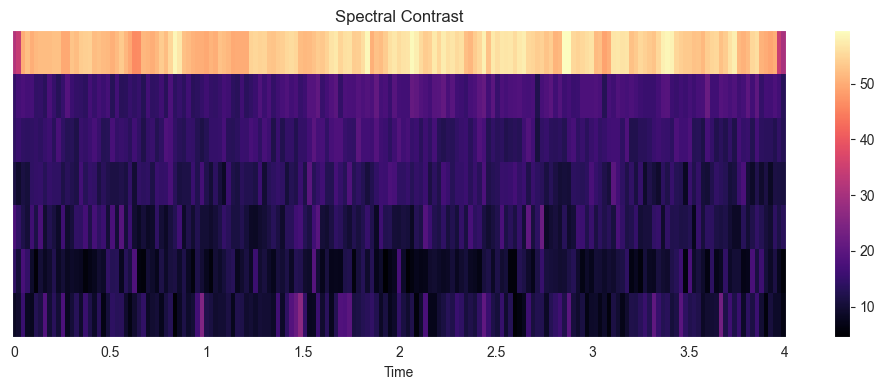

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features['spectral_contrast'], sr=22050, x_axis='time')
plt.title('Spectral Contrast')
plt.colorbar()
plt.tight_layout()
plt.show()

### Spectral Rolloff

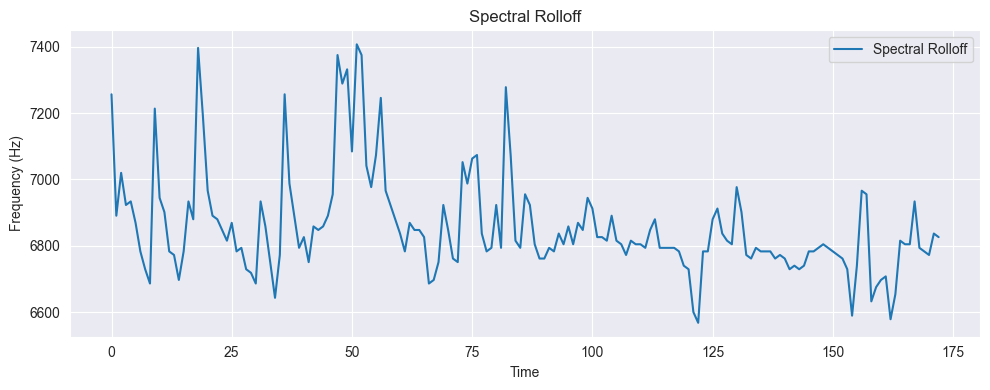

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(features['spectral_rolloff'].T, label="Spectral Rolloff")
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Rolloff')
plt.legend()
plt.tight_layout()
plt.show()

### Zero-Crossing Rate

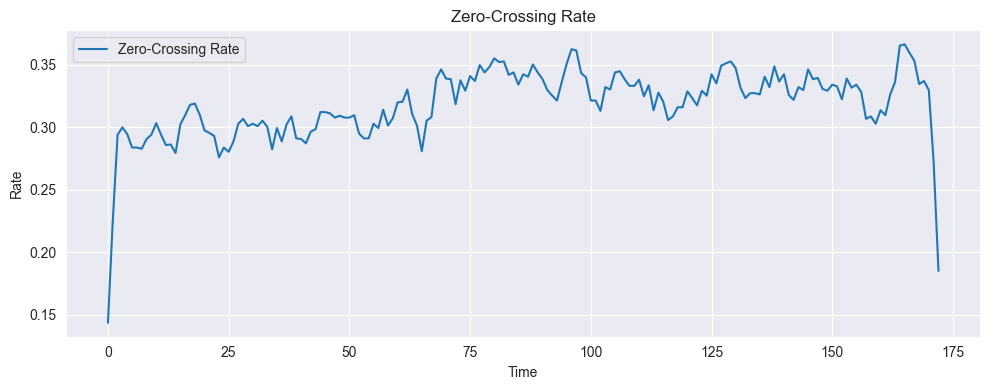

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(features['zero_crossing_rate'].T, label="Zero-Crossing Rate")
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Zero-Crossing Rate')
plt.legend()
plt.tight_layout()
plt.show()

### Extracting Features From All Audio Files


This cell checks if features have been previously extracted and saved in a pickle file. If not, it processes all audio files in the dataset, extracts the relevant features, and saves them for future use.

In [14]:
# Check if features have been extracted previously
features_pickle = 'urbansound8k_features.pkl'

if os.path.isfile(features_pickle):
    # Load pre-extracted features
    with open(features_pickle, 'rb') as f:
        data = pickle.load(f)
    print('Features loaded from pickle file.')
else:
    # Extract features from all audio files
    print('Extracting features from audio files...')
    data = []
    audio_parent_dir = 'UrbanSound8K/audio/'
    for index, row in df.iterrows():
        file_name = row['slice_file_name']
        fold = row['fold']
        class_id = row['classID']
        file_path = os.path.join(audio_parent_dir, f'fold{fold}', file_name)

        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append({
                'mel_spec': features['mel_spec'],
                'mfccs': features['mfccs'],
                'chroma': features['chroma'],
                'spectral_contrast': features['spectral_contrast'],
                'spectral_rolloff': features['spectral_rolloff'],
                'zero_crossing_rate': features['zero_crossing_rate'],
                'label': class_id,
                'fold': fold
            })
        else:
            print(f'File not found: {file_path}')

    # Save extracted features
    with open(features_pickle, 'wb') as f:
        pickle.dump(data, f)
    print('Feature extraction completed and data saved.')


Features loaded from pickle file.


## Preparing Data For Model Input

This cell organizes the extracted features into separate arrays for each feature type (Mel Spectrogram, MFCCs, Chroma, Spectral Contrast, Rolloff, and Zero-Crossing Rate) and the corresponding labels. These arrays are now ready for input into the CNN model.

In [15]:
# Prepare data for model input
features_df = pd.DataFrame(data)

# Separate features and labels
X_mel = np.array(features_df['mel_spec'].tolist())
X_mfcc = np.array(features_df['mfccs'].tolist())
X_chroma = np.array(features_df['chroma'].tolist())
X_contrast = np.array(features_df['spectral_contrast'].tolist())
X_rolloff = np.array(features_df['spectral_rolloff'].tolist())
X_zcr = np.array(features_df['zero_crossing_rate'].tolist())
y = np.array(features_df['label'].tolist())

# Reshape X_rolloff and X_zcr to remove the singleton dimension
X_rolloff = X_rolloff.reshape(X_rolloff.shape[0], -1)
X_zcr = X_zcr.reshape(X_zcr.shape[0], -1)


### Normalize Features

This function, `scale_features`, normalizes features using `StandardScaler`, ensuring a mean of 0 and a standard deviation of 1. It is used **after cross-validation splits** to fit the scaler only on training data, preventing data leakage and ensuring reliable evaluation metrics.

In [16]:
def scale_features(X, scaler):
    if X.ndim == 3:
        num_features = X.shape[1]
        X_flat = X.reshape(X.shape[0], -1)
        X_scaled_flat = scaler.fit_transform(X_flat)
        X_scaled = X_scaled_flat.reshape(X.shape[0], num_features, X.shape[2])
    elif X.ndim == 2:
        X_scaled = scaler.fit_transform(X)
    else:
        raise ValueError(f"Input X must be 2D or 3D array, but got array with shape {X.shape}")
    return X_scaled


### Encode Labels

We will use one-hot encoding for the labels.



In [17]:
# Encode labels
num_classes = 10

## Model Creation

We define input shapes to ensure compatibility with the **multi-input CNN model**, specifying the dimensions for each type of feature. This setup aligns with the expected input structure for the Conv2D and Conv1D layers:

- **2D Features** (Mel Spectrogram, MFCCs, Chroma, Spectral Contrast): Shapes are defined as `(height, width, 1)`, combining temporal and frequency information for Conv2D processing.
  - `mel_shape`: `(128, 320, 1)`
  - `mfcc_shape`: `(40, 320, 1)`
  - `chroma_shape`: `(12, 320, 1)`
  - `contrast_shape`: `(7, 320, 1)`

- **1D Features** (Spectral Rolloff, Zero-Crossing Rate): Shapes are defined as `(time_steps, 1)`, capturing temporal patterns for Conv1D processing.
  - `rolloff_shape`: `(320, 1)`
  - `zcr_shape`: `(320, 1)`

This configuration ensures that all feature types are formatted correctly for **specialized learning** within the CNN.

In [18]:
# Define shapes based on feature extraction
mel_shape = (128, 320, 1)        # Mel spectrogram shape
mfcc_shape = (40, 320, 1)        # MFCCs shape
chroma_shape = (12, 320, 1)      # Chroma shape
contrast_shape = (7, 320, 1)     # Spectral contrast shape
rolloff_shape = (320, 1)         # Spectral rolloff (1D)
zcr_shape = (320, 1)             # Zero-crossing rate (1D)



## Build the Model


### Related Work and Inspirations for the Model

The use of **multi-input Convolutional Neural Networks (CNNs)** for audio classification is a well-established approach, with various studies demonstrating the power of combining multiple feature representations to improve classification accuracy. The design of our model draws inspiration from the following research:

1. **Multi-Representation Knowledge Distillation for Audio Classification**  
   This study introduces a multi-input CNN with branches that process different audio representations independently, combining their outputs for enhanced classification. In our project, we adopt a similar strategy by using separate input streams for each feature type (e.g., Mel Spectrogram, MFCCs, Chroma, etc.), allowing the model to learn specialized patterns from each representation. The idea of merging these streams into a combined representation is directly inspired by this work.  
   ([Source](https://link.springer.com/article/10.1007/s11042-021-11610-8))

2. **An Ensemble of Convolutional Neural Networks for Audio Classification**  
   This research explores ensembles of pre-trained CNNs, each fine-tuned on a specific audio feature. By aggregating the results of these CNNs, the study demonstrates improved performance across diverse datasets. Similarly, our model processes each feature type (e.g., Spectral Contrast and Zero-Crossing Rate) independently through dedicated CNN streams. Instead of using an ensemble of pre-trained networks, we combine the streams into a unified model, inspired by the concept of leveraging diverse feature-specific processing.  
   ([Source](https://www.mdpi.com/2076-3417/11/13/5796))

3. **Audio Classification Using Braided Convolutional Neural Networks**  
   This paper proposes a braided CNN architecture where different audio features are processed in parallel to capture both time and frequency components effectively. Our architecture mirrors this by employing parallel streams for 2D features (e.g., Mel Spectrogram and MFCCs) and 1D features (e.g., Rolloff and ZCR), ensuring that both temporal and frequency aspects are well represented. The use of Conv2D and Conv1D layers for different feature types in our model takes direct inspiration from this work.  
   ([Source](https://ietresearch.onlinelibrary.wiley.com/doi/pdfdirect/10.1049/iet-spr.2019.0381))

---

### Contribution of Our Model

Our multi-input CNN combines insights from these studies, focusing on:
- Specialized processing of diverse feature types using independent CNN streams.
- Integration of these streams into a combined representation for robust decision-making.
- Flexible use of both 2D and 1D convolutional layers to process spectral and temporal features effectively.

This approach ensures that the strengths of each feature type are fully utilized, leading to improved performance in urban sound classification tasks.

In [19]:
def cnn_model():
    # Mel Spectrogram Input Stream
    mel_input = Input(shape=mel_shape, name='mel_input')
    mel_layer = Conv2D(16, kernel_size=(7, 7), strides=3, padding='same', activation='relu', kernel_initializer='he_normal')(mel_input)
    mel_layer = MaxPooling2D(pool_size=(4, 4), padding='same')(mel_layer)
    mel_layer = Dropout(0.4)(mel_layer)
    mel_layer = Conv2D(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mel_layer)
    mel_layer = MaxPooling2D(pool_size=(3, 3), padding='same')(mel_layer)
    mel_layer = Dropout(0.3)(mel_layer)
    mel_layer = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mel_layer)
    mel_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(mel_layer)
    mel_layer = Dropout(0.2)(mel_layer)
    mel_layer = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mel_layer)
    mel_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(mel_layer)
    mel_layer = Dropout(0.2)(mel_layer)
    mel_layer = Flatten()(mel_layer)
    
    # MFCCs Input Stream
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')
    mfcc_layer = Conv2D(16, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mfcc_input)
    mfcc_layer = MaxPooling2D(pool_size=(3, 3), padding='same')(mfcc_layer)
    mfcc_layer = Dropout(0.2)(mfcc_layer)
    mfcc_layer = Conv2D(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mfcc_layer)
    mfcc_layer = MaxPooling2D(pool_size=(3, 3), padding='same')(mfcc_layer)
    mfcc_layer = Dropout(0.2)(mfcc_layer)
    mfcc_layer = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mfcc_layer)
    mfcc_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(mfcc_layer)
    mfcc_layer = Dropout(0.2)(mfcc_layer)
    mfcc_layer = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(mfcc_layer)
    mfcc_layer = Dropout(0.2)(mfcc_layer)
    mfcc_layer = Flatten()(mfcc_layer)
    
    # Chroma Input Stream
    chroma_input = Input(shape=chroma_shape, name='chroma_input')
    chroma_layer = Conv2D(16, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(chroma_input)
    chroma_layer = MaxPooling2D(pool_size=(3, 3), padding='same')(chroma_layer)
    chroma_layer = Dropout(0.2)(chroma_layer)
    chroma_layer = Conv2D(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(chroma_layer)
    chroma_layer = MaxPooling2D(pool_size=(3, 3), padding='same')(chroma_layer)
    chroma_layer = Dropout(0.2)(chroma_layer)
    chroma_layer = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(chroma_layer)
    chroma_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(chroma_layer)
    chroma_layer = Dropout(0.2)(chroma_layer)
    chroma_layer = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(chroma_layer)
    chroma_layer = Dropout(0.2)(chroma_layer)
    chroma_layer = Flatten()(chroma_layer)
    
    # Spectral Contrast Input Stream
    contrast_input = Input(shape=contrast_shape, name='contrast_input')
    contrast_layer = Conv2D(16, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(contrast_input)
    contrast_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(contrast_layer)
    contrast_layer = Dropout(0.2)(contrast_layer)
    contrast_layer = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(contrast_layer)
    contrast_layer = MaxPooling2D(pool_size=(2, 2), padding='same')(contrast_layer)
    contrast_layer = Dropout(0.2)(contrast_layer)
    contrast_layer = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(contrast_layer)
    contrast_layer = Dropout(0.2)(contrast_layer)
    contrast_layer = Flatten()(contrast_layer)
    
    # Spectral Rolloff Input Stream
    rolloff_input = Input(shape=rolloff_shape, name='rolloff_input')
    rolloff_layer = Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu')(rolloff_input)
    rolloff_layer = MaxPooling1D(pool_size=2, padding='same')(rolloff_layer)
    rolloff_layer = Dropout(0.2)(rolloff_layer)
    rolloff_layer = Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu')(rolloff_layer)
    rolloff_layer = MaxPooling1D(pool_size=2, padding='same')(rolloff_layer)
    rolloff_layer = Dropout(0.2)(rolloff_layer)
    rolloff_layer = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(rolloff_layer)
    rolloff_layer = Flatten()(rolloff_layer)
    
    # Zero-Crossing Rate Input Stream
    zcr_input = Input(shape=zcr_shape, name='zcr_input')
    zcr_layer = Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu')(zcr_input)
    zcr_layer = MaxPooling1D(pool_size=2, padding='same')(zcr_layer)
    zcr_layer = Dropout(0.2)(zcr_layer)
    zcr_layer = Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu')(zcr_layer)
    zcr_layer = MaxPooling1D(pool_size=2, padding='same')(zcr_layer)
    zcr_layer = Dropout(0.2)(zcr_layer)
    zcr_layer = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(zcr_layer)
    zcr_layer = Flatten()(zcr_layer)
    
    # Combine all streams
    combined = concatenate([
        mel_layer, mfcc_layer, chroma_layer, contrast_layer, rolloff_layer, zcr_layer
    ])
    
    # Fully connected layers with regularization
    combined = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05), kernel_initializer='he_normal')(combined)
    combined = Dropout(0.2)(combined)
    combined = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05), kernel_initializer='he_normal')(combined)
    combined = Dropout(0.2)(combined)
    combined = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05), kernel_initializer='he_normal')(combined)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(combined)
    
    # Define the model
    model = Model(inputs=[
        mel_input, mfcc_input, chroma_input, contrast_input, rolloff_input, zcr_input
    ], outputs=output)
    
    return model

In [20]:
model = cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_input           │ (None, 128, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 43, 107,   │        800 │ mel_input[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mfcc_input          │ (None, 40, 320,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chroma_input        │ (None, 12, 320,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 27,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 320,   │        416 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 12, 320,   │        416 │ chroma_input[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 27,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 107,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 107,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 27,    │     12,832 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 14, 107,   │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 4, 107,    │          0 │ max_pooling2d_7[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contrast_input      │ (None, 7, 320, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 9, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 107,   │     12,832 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 4, 107,    │     12,832 │ dropout_8[0][0] 

 Total params: 16,154,250 (61.62 MB)

 Trainable params: 16,154,250 (61.62 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Reshape the Data

The `ready_data` function prepares the data for training, validation, and testing in a **10-fold cross-validation** setup. Key steps in the function include:

1. **Splitting Data**:
   - Assigns data into training, validation, and test sets using fold assignments for stratified sampling.

2. **Feature Adjustment**:
   - **2D Features (e.g., Mel Spectrogram, MFCC, Chroma)**:
     - Pad or truncate the width dimension to ensure uniform shapes.
     - Adds a channel dimension for compatibility with CNNs.
   - **1D Features (e.g., Spectral Rolloff, Zero-Crossing Rate)**:
     - Handles feature consistency by padding or truncating to a fixed size.
     - Combines `rolloff` and `zcr` features into a single array with two channels.

3. **Efficient Memory Management**:
   - Unused variables and intermediate results are cleared to reduce memory consumption.

4. **Output**:
   - Returns the processed train, validation, and test sets for all features and labels, ready for input into the CNN model.

In [22]:
def ready_data(fold, features_df, X_mel, X_mfcc, X_chroma, X_contrast,
               X_rolloff, X_zcr, y, TARGET_WIDTH=320):
    # Use the specified fold as the test set
    test_idx = (features_df['fold'] == fold).values

    # Use the next fold as the validation set (cycling back to 1 after 10)
    validation_fold = (fold % 10) + 1
    val_idx = (features_df['fold'] == validation_fold).values

    # Use the remaining folds as the training set
    train_idx = ~(test_idx | val_idx)

    # Function to pad or truncate 2D features
    def pad_or_truncate_2d(X):
        num_samples, height, width = X.shape
        if width > TARGET_WIDTH:
            X = X[:, :, :TARGET_WIDTH]  # Truncate
        elif width < TARGET_WIDTH:
            pad_width = TARGET_WIDTH - width
            X = np.pad(X, ((0, 0), (0, 0), (0, pad_width)), mode='constant')  # Pad
        return X


    # Function to pad or truncate 1D features
    def pad_or_truncate_1d(X):
        num_samples, width = X.shape
        if width > TARGET_WIDTH:
            X = X[:, :TARGET_WIDTH]  # Truncate
        elif width < TARGET_WIDTH:
            pad_width = TARGET_WIDTH - width
            X = np.pad(X, ((0, 0), (0, pad_width)), mode='constant')  # Pad
        return X


    # Adjust features for train, validation, and test sets
    X_train_mel = pad_or_truncate_2d(X_mel[train_idx])
    X_val_mel = pad_or_truncate_2d(X_mel[val_idx])
    X_test_mel = pad_or_truncate_2d(X_mel[test_idx])

    X_train_mfcc = pad_or_truncate_2d(X_mfcc[train_idx])
    X_val_mfcc = pad_or_truncate_2d(X_mfcc[val_idx])
    X_test_mfcc = pad_or_truncate_2d(X_mfcc[test_idx])

    X_train_chroma = pad_or_truncate_2d(X_chroma[train_idx])
    X_val_chroma = pad_or_truncate_2d(X_chroma[val_idx])
    X_test_chroma = pad_or_truncate_2d(X_chroma[test_idx])

    X_train_contrast = pad_or_truncate_2d(X_contrast[train_idx])
    X_val_contrast = pad_or_truncate_2d(X_contrast[val_idx])
    X_test_contrast = pad_or_truncate_2d(X_contrast[test_idx])

    X_train_rolloff = pad_or_truncate_1d(X_rolloff[train_idx])
    X_val_rolloff = pad_or_truncate_1d(X_rolloff[val_idx])
    X_test_rolloff = pad_or_truncate_1d(X_rolloff[test_idx])

    X_train_zcr = pad_or_truncate_1d(X_zcr[train_idx])
    X_val_zcr = pad_or_truncate_1d(X_zcr[val_idx])
    X_test_zcr = pad_or_truncate_1d(X_zcr[test_idx])

    # Extract labels
    y_train = y[train_idx]
    y_val = y[val_idx]
    y_test = y[test_idx]

    return (X_train_mel, X_train_mfcc, X_train_chroma, X_train_contrast, X_train_rolloff, X_train_zcr, y_train,
            X_val_mel, X_val_mfcc, X_val_chroma, X_val_contrast, X_val_rolloff, X_val_zcr, y_val,
            X_test_mel, X_test_mfcc, X_test_chroma, X_test_contrast, X_test_rolloff, X_test_zcr, y_test)

### Train the Model

- **Data Splitting**: Uses the predefined folds provided in the UrbanSound8K dataset to create train, validation, and test sets for each fold.
- **Model Training**: Trains a CNN with early stopping and learning rate reduction.
- **Evaluation**: Saves metrics (accuracy, loss, confusion matrix) and models for each fold.
- **Outcome**: Robust performance assessment across all 10 folds.

The training process included the use of early stopping and learning rate reduction callbacks to optimize model performance and prevent overfitting. Specifically:

1. **Early Stopping**: The training was configured with an early stopping mechanism, monitoring the validation loss with a patience of 10 epochs. This ensured that the training process terminated early when no further improvement in validation loss was observed, reducing the risk of overfitting.

2. **Learning Rate Reduction**: The learning rate was dynamically reduced by a factor of 0.5 if the validation loss plateaued for 5 consecutive epochs, with a minimum learning rate of $1 \times 10^{-6}$. This allowed the model to make finer adjustments during later stages of training.

In [24]:
# Number of epochs and batch size
EPOCHS = 50
BATCH_SIZE = 64

# Initialize list to store metrics for each fold
fold_metrics = []

# Directory to save metrics and models
os.makedirs("assets/kfold_metrics", exist_ok=True)

# Perform 10-fold cross-validation using predefined folds
for fold in range(1, 11):
    print(f"\nProcessing Fold {fold}:")

    # Check if metrics for this fold already exist
    metrics_path = f"assets/kfold_metrics/metrics_fold{fold}.pkl"
    model_path = f"assets/kfold_metrics/model_fold{fold}.keras"
    if os.path.exists(metrics_path) and os.path.exists(model_path):
        print(f"Fold {fold} already completed. Skipping...")
        continue

    # Prepare data for this fold using the updated ready_data function
    (X_train_mel, X_train_mfcc, X_train_chroma, X_train_contrast, X_train_rolloff, X_train_zcr, y_train,
     X_val_mel, X_val_mfcc, X_val_chroma, X_val_contrast, X_val_rolloff, X_val_zcr, y_val,
     X_test_mel, X_test_mfcc, X_test_chroma, X_test_contrast, X_test_rolloff, X_test_zcr, y_test) = ready_data(
        fold, features_df, X_mel, X_mfcc, X_chroma, X_contrast, X_rolloff, X_zcr, y
    )

    # Helper function to scale and add channel dimensions
    def scale_and_reshape(X_train, X_val, X_test, scaler):
        """
        Scale features and add channel dimension after scaling.
        """
        X_train_scaled = scale_features(X_train, scaler)
        X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
        return X_train_scaled[..., np.newaxis], X_val_scaled[..., np.newaxis], X_test_scaled[..., np.newaxis]

    # Scale features individually per fold
    scaler_mel = StandardScaler()
    X_train_mel_scaled, X_val_mel_scaled, X_test_mel_scaled = scale_and_reshape(X_train_mel, X_val_mel, X_test_mel, scaler_mel)

    scaler_mfcc = StandardScaler()
    X_train_mfcc_scaled, X_val_mfcc_scaled, X_test_mfcc_scaled = scale_and_reshape(X_train_mfcc, X_val_mfcc, X_test_mfcc, scaler_mfcc)

    scaler_chroma = StandardScaler()
    X_train_chroma_scaled, X_val_chroma_scaled, X_test_chroma_scaled = scale_and_reshape(X_train_chroma, X_val_chroma, X_test_chroma, scaler_chroma)

    scaler_contrast = StandardScaler()
    X_train_contrast_scaled, X_val_contrast_scaled, X_test_contrast_scaled = scale_and_reshape(X_train_contrast, X_val_contrast, X_test_contrast, scaler_contrast)

    # For 1D features (Rolloff and ZCR)
    scaler_rolloff = StandardScaler()
    X_train_rolloff_scaled = scale_features(X_train_rolloff, scaler_rolloff)
    X_val_rolloff_scaled = scaler_rolloff.transform(X_val_rolloff)
    X_test_rolloff_scaled = scaler_rolloff.transform(X_test_rolloff)

    scaler_zcr = StandardScaler()
    X_train_zcr_scaled = scale_features(X_train_zcr, scaler_zcr)
    X_val_zcr_scaled = scaler_zcr.transform(X_val_zcr)
    X_test_zcr_scaled = scaler_zcr.transform(X_test_zcr)

    # Combine 1D features after adding channel dimension
    def combine_1d_features(rolloff, zcr):
        rolloff = rolloff[..., np.newaxis]
        zcr = zcr[..., np.newaxis]
        return np.concatenate([rolloff, zcr], axis=-1)

    X_train_1d = combine_1d_features(X_train_rolloff_scaled, X_train_zcr_scaled)
    X_val_1d = combine_1d_features(X_val_rolloff_scaled, X_val_zcr_scaled)
    X_test_1d = combine_1d_features(X_test_rolloff_scaled, X_test_zcr_scaled)

    # One-hot encode the labels
    y_train_encoded = to_categorical(y_train, num_classes)
    y_val_encoded = to_categorical(y_val, num_classes)
    y_test_encoded = to_categorical(y_test, num_classes)

    # Create and compile the model
    model = cnn_model()
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        {
            "mel_input": X_train_mel_scaled,
            "mfcc_input": X_train_mfcc_scaled,
            "chroma_input": X_train_chroma_scaled,
            "contrast_input": X_train_contrast_scaled,
            "rolloff_input": X_train_1d[:, :, 0:1],
            "zcr_input": X_train_1d[:, :, 1:2]
        },
        y_train_encoded,
        validation_data=(
            {
                "mel_input": X_val_mel_scaled,
                "mfcc_input": X_val_mfcc_scaled,
                "chroma_input": X_val_chroma_scaled,
                "contrast_input": X_val_contrast_scaled,
                "rolloff_input": X_val_1d[:, :, 0:1],
                "zcr_input": X_val_1d[:, :, 1:2]
            },
            y_val_encoded
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
    )

    # Evaluate the model on the test set
    evaluation = model.evaluate(
        {
            "mel_input": X_test_mel_scaled,
            "mfcc_input": X_test_mfcc_scaled,
            "chroma_input": X_test_chroma_scaled,
            "contrast_input": X_test_contrast_scaled,
            "rolloff_input": X_test_1d[:, :, 0:1],
            "zcr_input": X_test_1d[:, :, 1:2]
        },
        y_test_encoded,
        verbose=1
    )

    # Predict labels on the test set
    y_pred = model.predict(
        {
            "mel_input": X_test_mel_scaled,
            "mfcc_input": X_test_mfcc_scaled,
            "chroma_input": X_test_chroma_scaled,
            "contrast_input": X_test_contrast_scaled,
            "rolloff_input": X_test_1d[:, :, 0:1],
            "zcr_input": X_test_1d[:, :, 1:2]
        },
        verbose=1
    )

    # Convert predictions and true labels to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_encoded, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Save metrics for this fold
    metrics = {
        "fold": fold,
        "loss": evaluation[0],
        "accuracy": evaluation[1],
        "confusion_matrix": cm,
        "history": history.history
    }
    fold_metrics.append(metrics)

    # Save metrics and model
    with open(metrics_path, "wb") as f:
        pickle.dump(metrics, f)
    model.save(model_path, save_format="keras")

    print(f"Fold {fold} completed and saved.")

    # Clear session to prevent memory leaks
    tf.keras.backend.clear_session()


Processing Fold 1:
Fold 1 already completed. Skipping...

Processing Fold 2:
Fold 2 already completed. Skipping...

Processing Fold 3:
Fold 3 already completed. Skipping...

Processing Fold 4:
Fold 4 already completed. Skipping...

Processing Fold 5:
Fold 5 already completed. Skipping...

Processing Fold 6:
Fold 6 already completed. Skipping...

Processing Fold 7:
Fold 7 already completed. Skipping...

Processing Fold 8:
Fold 8 already completed. Skipping...

Processing Fold 9:
Fold 9 already completed. Skipping...

Processing Fold 10:
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 599ms/step - accuracy: 0.2005 - loss: 81.4796 - val_accuracy: 0.4296 - val_loss: 25.0174 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 318ms/step - accuracy: 0.4149 - loss: 20.1991 - val_accuracy: 0.4582 - val_loss: 11.0312 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 277ms/step - accuracy: 0.4992 - loss: 9.4688 - val_accuracy: 0.5716 - val_loss: 6.3130 - learning_r

Fold 10 completed and saved.


# Evaluate the Model

We load from the files we saved the metrics registered during training

In [25]:
fold_metrics = []

# Check if the directory containing the metrics exists
if os.path.exists("assets/kfold_metrics"):
    for fold in range(1, 11):
        metrics_path = f"assets/kfold_metrics/metrics_fold{fold}.pkl"
        if os.path.isfile(metrics_path):
            with open(metrics_path, "rb") as f:
                metrics = pickle.load(f)
                fold_metrics.append(metrics)
        else:
            print(f"Metrics file for fold {fold} not found.")
else:
    print("No 'assets/kfold_metrics' directory found. Please ensure that models have been trained and metrics are saved.")


## Confusion Matrix

### Confusion Matrix for Each Fold

Here we can observe the confusion matrix for each fold, all folds look alike. We do notice that the model fails at distinguishing between some ofn the classes of the dataset, but it has good accuracy overall.

In [ ]:
# Plot confusion matrices for all folds
fig, ax = plt.subplots(5, 2, figsize=(15, 3 * len(fold_metrics)))

for i, metrics in enumerate(fold_metrics):
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='RdYlGn', ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(f'Confusion Matrix: Fold {i + 1}')

plt.tight_layout()
plt.show()

### Cumulative confusion matrix

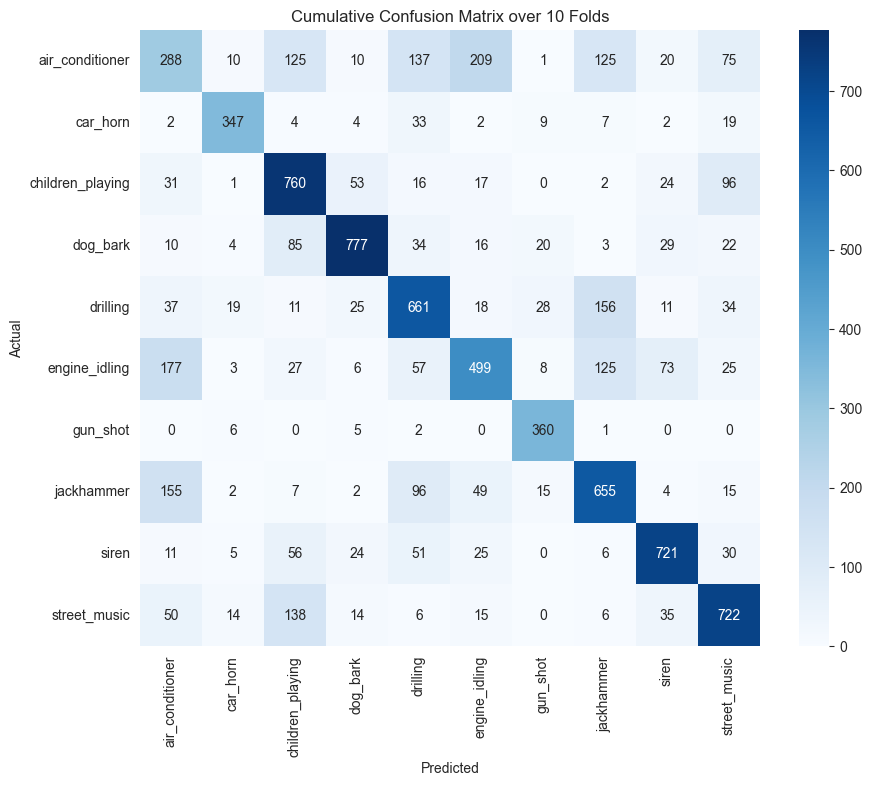

In [28]:
# Initialize the cumulative confusion matrix
confusion_matrix_total = np.zeros((num_classes, num_classes), dtype=int)

# Accumulate confusion matrices from all folds
for metrics in fold_metrics:
    confusion_matrix_total += metrics.get('confusion_matrix', np.zeros((num_classes, num_classes), dtype=int))

# Ensure the cumulative confusion matrix is valid
if confusion_matrix_total.sum() == 0:
    raise ValueError("Cumulative confusion matrix is empty. Please check the metrics['confusion_matrix'] data.")

# Plot cumulative confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_total, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Cumulative Confusion Matrix over 10 Folds')
plt.show()


### Cumulative Confusion Matrix with Percentages

In [ ]:
# Combine confusion matrices from all folds
cumulative_cm = np.zeros_like(fold_metrics[0]['confusion_matrix'], dtype=float)
for metrics in fold_metrics:
    cumulative_cm += metrics['confusion_matrix']

# Normalize confusion matrix
cumulative_cm = cumulative_cm / cumulative_cm.sum(axis=1)[:, np.newaxis]

# Plot cumulative confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cumulative_cm, annot=True, fmt=".2%", linewidths=.5, square=True, cmap='RdYlGn')
plt.title('Cumulative Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The cumulative confusion matrix indicates to us that the CNN achieves high accuracy for specific classes such as children_playing, dog_bark, siren, street_music, and gun_shot, with a substantial number of correct predictions. However, the model underperforms in differentiating classes such as air_conditioner, engine_idling, and jackhammer, showing notable confusion with other acoustically similar classes, this is exptected with mechanical noises that are very simillar in nature with their repeated rythms. With this analysis we can conclude that the model does a decent job at distinguishiong sounds that are very diferent

### Training and Validation Accuracy

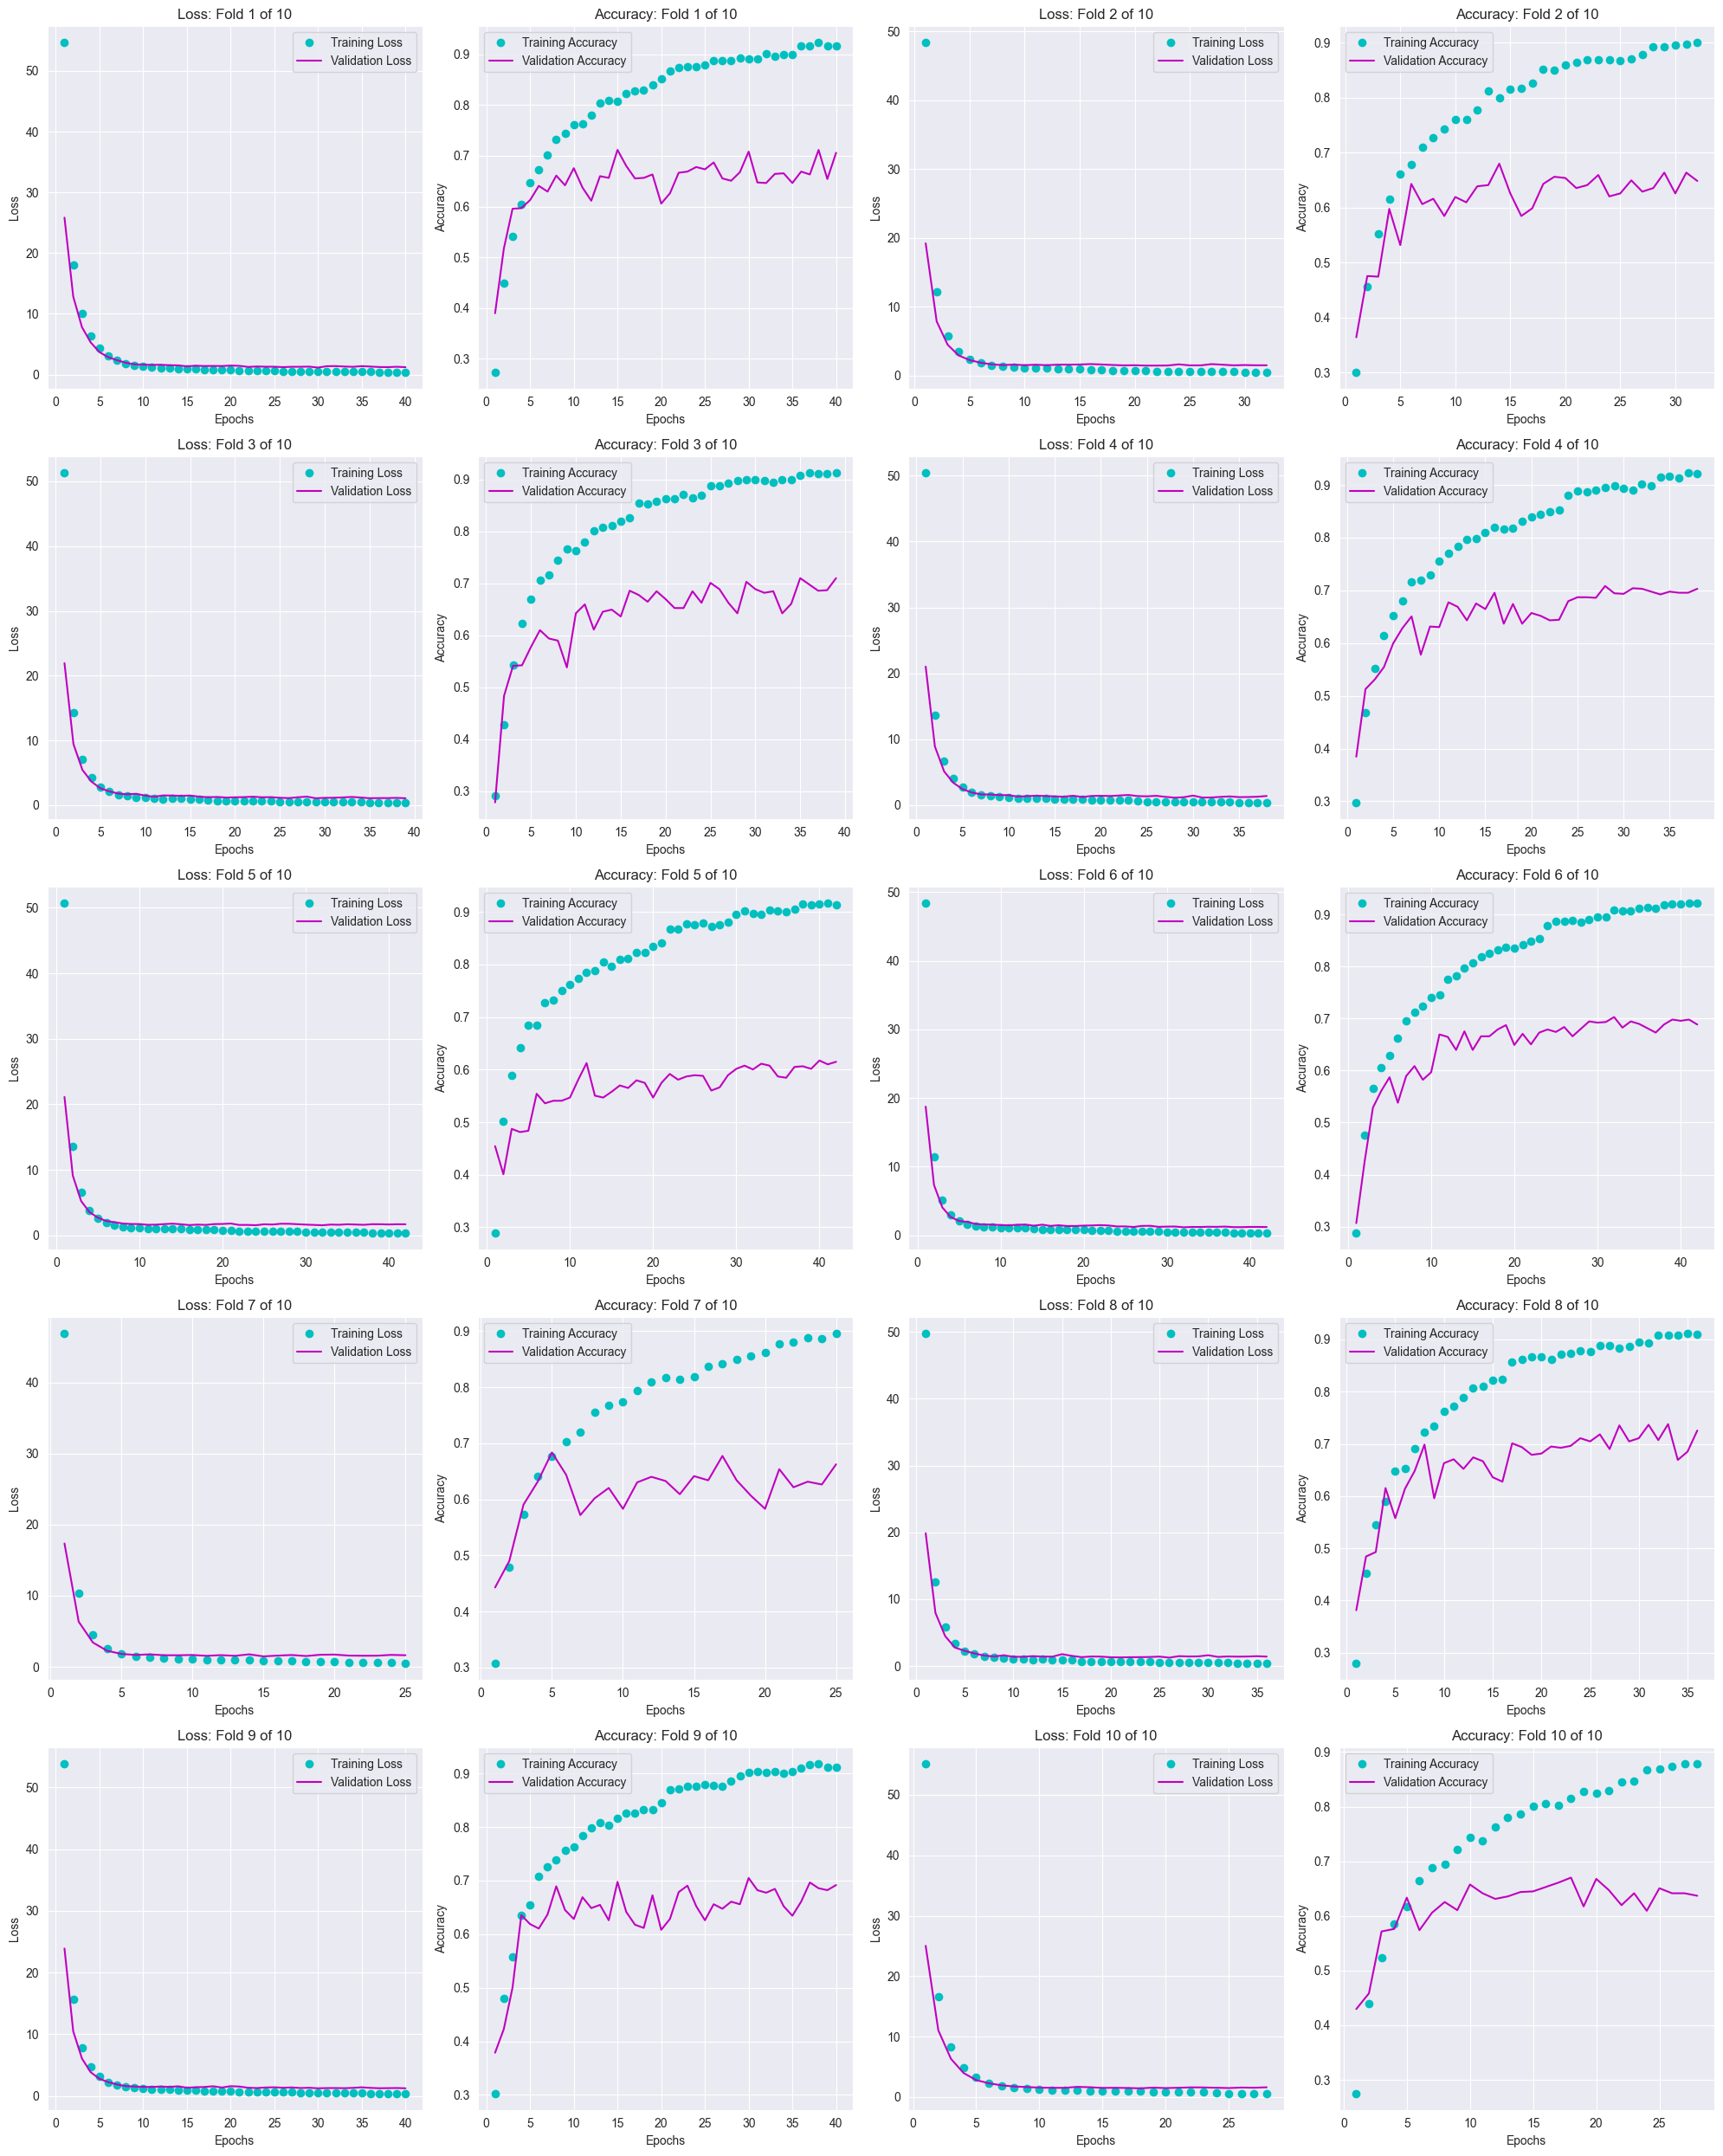

In [30]:
EPOCHS = 50

# Prepare subplots for visualizing training/validation metrics
fig, ax = plt.subplots(5, 4, figsize=(20, 2.5 * len(fold_metrics)))

line = 0
for i in range(0, len(fold_metrics), 2):
    # Extract history for fold 1 and fold 2
    history_dict1 = fold_metrics[i].get('history')
    history_dict2 = fold_metrics[i + 1].get('history')

    # Use the correct x-axis range for fold 1
    epochs_fold1 = range(1, len(history_dict1['loss']) + 1)
    loss_values1 = history_dict1['loss']
    acc_values1 = history_dict1['accuracy']
    val_loss_values1 = history_dict1['val_loss']
    val_acc_values1 = history_dict1['val_accuracy']

    # Use the correct x-axis range for fold 2
    epochs_fold2 = range(1, len(history_dict2['loss']) + 1)
    loss_values2 = history_dict2['loss']
    acc_values2 = history_dict2['accuracy']
    val_loss_values2 = history_dict2['val_loss']
    val_acc_values2 = history_dict2['val_accuracy']

    # Plot fold 1
    ax[line, 0].plot(epochs_fold1, loss_values1, 'co', label='Training Loss')
    ax[line, 0].plot(epochs_fold1, val_loss_values1, 'm', label='Validation Loss')
    ax[line, 0].set_title(f'Loss: Fold {i + 1} of 10')
    ax[line, 0].set_xlabel('Epochs')
    ax[line, 0].set_ylabel('Loss')
    ax[line, 0].legend()

    ax[line, 1].plot(epochs_fold1, acc_values1, 'co', label='Training Accuracy')
    ax[line, 1].plot(epochs_fold1, val_acc_values1, 'm', label='Validation Accuracy')
    ax[line, 1].set_title(f'Accuracy: Fold {i + 1} of 10')
    ax[line, 1].set_xlabel('Epochs')
    ax[line, 1].set_ylabel('Accuracy')
    ax[line, 1].legend()

    # Plot fold 2
    ax[line, 2].plot(epochs_fold2, loss_values2, 'co', label='Training Loss')
    ax[line, 2].plot(epochs_fold2, val_loss_values2, 'm', label='Validation Loss')
    ax[line, 2].set_title(f'Loss: Fold {i + 2} of 10')
    ax[line, 2].set_xlabel('Epochs')
    ax[line, 2].set_ylabel('Loss')
    ax[line, 2].legend()

    ax[line, 3].plot(epochs_fold2, acc_values2, 'co', label='Training Accuracy')
    ax[line, 3].plot(epochs_fold2, val_acc_values2, 'm', label='Validation Accuracy')
    ax[line, 3].set_title(f'Accuracy: Fold {i + 2} of 10')
    ax[line, 3].set_xlabel('Epochs')
    ax[line, 3].set_ylabel('Accuracy')
    ax[line, 3].legend()

    line += 1

plt.tight_layout()
plt.show()


The training and validation loss/accuracy curves across the 10 folds show that the model's training process was stable and effective, thanks to the use of early stopping and learning rate reduction callbacks. The training loss consistently decreases across all folds, indicating that the model learns well from the data. The validation accuracy improves steadily in the initial epochs and then plateaus, which aligns with the early stopping mechanism that was set to monitor validation loss with a patience of 10 epochs. This helped prevent overfitting by stopping training when no further improvements were observed. The learning rate reduction callback, which reduced the learning rate by a factor of 0.5 after 5 epochs of stagnant validation loss, also contributed to the smooth convergence seen in most folds by allowing finer adjustments in later epochs. While the overall trends are consistent across folds, slight variability in validation accuracy can be seen, likely due to differences in data splits and the challenges of acoustically similar classes in the UrbanSound8K dataset. These callbacks ensured efficient training, avoiding unnecessary epochs and supporting the model’s ability to generalize well.

### Average Accuracy and Standard Deviation

In [31]:
# Calculate training, validation, and test accuracies
train_acc = [max(metrics['history']['accuracy']) for metrics in fold_metrics]
val_acc = [max(metrics['history']['val_accuracy']) for metrics in fold_metrics]
test_acc = [metrics['accuracy'] for metrics in fold_metrics]

# Calculate means and standard deviations
avg_train_acc = np.mean(train_acc)
std_train_acc = np.std(train_acc)
avg_val_acc = np.mean(val_acc)
std_val_acc = np.std(val_acc)
avg_test_acc = np.mean(test_acc)
std_test_acc = np.std(test_acc)

# Print results
print(f"Train Accuracy: {avg_train_acc * 100:.2f}% (±{std_train_acc * 100:.2f}%)")
print(f"Validation Accuracy: {avg_val_acc * 100:.2f}% (±{std_val_acc * 100:.2f}%)")
print(f"Test Accuracy: {avg_test_acc * 100:.2f}% (±{std_test_acc * 100:.2f}%)")

Train Accuracy: 90.97% (±1.38%)
Validation Accuracy: 69.27% (±3.10%)
Test Accuracy: 66.27% (±4.11%)


The model achieves decent results, with a test accuracy of 66%, indicating it correctly identifies most classes. However, the high training accuracy (91%) compared to validation (69%) and test accuracy suggests overfitting, likely due to the model’s complexity or challenges in distinguishing acoustically similar classes

### Class-Wise Accuracy Across Folds

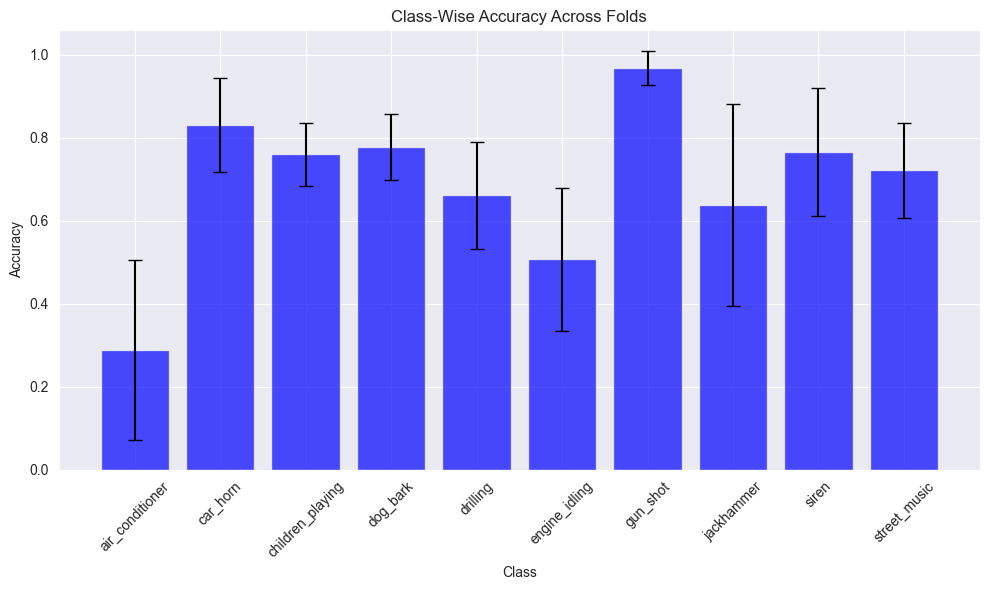

In [34]:
# Initialize class-wise accuracy matrix
class_wise_accuracy = np.zeros((len(fold_metrics), num_classes))

# Compute class-wise accuracy for each fold
for i, metrics in enumerate(fold_metrics):
    cm = metrics['confusion_matrix']
    class_wise_accuracy[i, :] = cm.diagonal() / cm.sum(axis=1)

# Calculate mean and std across folds for each class
class_mean_accuracy = class_wise_accuracy.mean(axis=0)
class_std_accuracy = class_wise_accuracy.std(axis=0)

# Plot class-wise accuracy with error bars
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), class_mean_accuracy, yerr=class_std_accuracy, capsize=5, alpha=0.7, color='b')
plt.xticks(range(num_classes), class_labels, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.title('Class-Wise Accuracy Across Folds')
plt.tight_layout()
plt.show()


The class-wise accuracy plot shows strong performance for classes like *gun_shot*, *car_horn*, and *dog_bark*, with high average accuracy and smaller error bars, indicating consistency across folds. However, classes such as *air_conditioner* and *engine_idling* have significantly lower accuracy and larger variability, reflecting difficulty in distinguishing these acoustically similar sounds. This highlights the model's strengths in distinct classes but its challenges in more overlapping categories.

# Conclusion

In conclusion, the CNN demonstrates commendable performance on the UrbanSound8K dataset, achieving high accuracy in distinguishing distinct sound classes. However, it encounters challenges with acoustically similar classes, such as *air_conditioner*, *engine_idling*, and *jackhammer*, leading to increased misclassifications. This suggests that while the model effectively captures unique features of certain sounds, it struggles with overlapping acoustic characteristics present in similar classes. To enhance generalization and address class overlap, future work could explore advanced data augmentation techniques, incorporation of attention mechanisms, or the development of more sophisticated architectures capable of discerning subtle differences in acoustically similar sounds. These strategies aim to improve the model's robustness and overall classification accuracy across all sound categories. 

# Bibliography and Sources

- [Nanni, L., Maguolo, G., Brahnam, S., & Paci, M. (2020). An Ensemble of Convolutional Neural Networks for Audio Classification.](https://arxiv.org/abs/2007.07966)

- [Wolf-Monheim, F. (2024). Spectral and Rhythm Features for Audio Classification with Deep Convolutional Neural Networks.](https://arxiv.org/abs/2410.06927)

- [Nanni, L., Maguolo, G., Brahnam, S., & Paci, M. (2021). An Ensemble of Convolutional Neural Networks for Audio Classification.](https://www.mdpi.com/2076-3417/11/13/5796)

- [Morales, J. Y., Castillo, J. D., León, B. M., Ferro Escobar, R., & Gaona, A. E. (2020). Audio Scene Classification Based on Convolutional Neural Networks: An Evaluation of Multiple Features and Topologies in Short Time Segments. In AETA 2019 - Recent Advances in Electrical Engineering and Related Sciences: Theory and Application (pp. 414–422).](https://link.springer.com/chapter/10.1007/978-3-030-53021-1_42)

- [Zeng, Y., Mao, H., Peng, D., & Yi, Z. (2019). Spectrogram Based Multi-Task Audio Classification.](https://arxiv.org/abs/1904.04989)